# Analysis

## Paths

Define your paths to the .md files here.

In [1]:
trove_path = "../troves"
primitive_path = "../primitives"

## Imports

In [2]:
from __future__ import annotations
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from collections import defaultdict, Counter
import os
from tqdm import tqdm
import json
from pathlib import Path
from statistics import mean, stdev
from itertools import chain
import pandas as pd



from compute_matching import get_trove_accuracies, get_primitive_accuracies
from comp_budgets import *
from tasks_per_mode import *
from solution_diversity import get_solution_diversity


## Statistics

In [3]:
# total number of tasks per category
task_totals = {
    "algebra": 881,
    "counting": 291,
    "geometry": 237,
    "intermediate": 503,
    "number": 497,
    "prealgebra": 636,
    "precalculus": 156
}

total_tasks = 3201


#originally reported results
primitive_org_data = {
    "algebra": 0.15, "counting": 0.14, "geometry": 0.06,
    "intermediate": 0.05, "number": 0.16,
    "prealgebra": 0.21, "precalculus": 0.10, "MATH": 0.12
}
trove_org_data = {
    "algebra": 0.25, "counting": 0.26, "geometry": 0.08,
    "intermediate": 0.11, "number": 0.25,
    "prealgebra": 0.29, "precalculus": 0.17, "MATH": 0.20
}

## Compute Matching

We match the Primitive baseline for equal compute of K=15, as it was chosen for TroVE. For this, we also retrieve from the data, which accuracies were achieved across differeent choices of selection mechanisms - the oracle, the normal majority voting and the improved version as described in the paper.

In [4]:
# we retrieve the accuracies per categgory, seed and selection mechanism
trove_results = get_trove_accuracies(trove_path)
primitive_results = get_primitive_accuracies(primitive_path)


# Organize by category name (e.g., algebra, counting)
categories = sorted(set(Path(k).name for k in trove_results) | set(Path(k).name for k in primitive_results))

means = {key: [] for key in ["trove_normal", "trove_oracle", "trove_new_eval", "primitive_normal", "primitive_oracle"]}
stds = {key: [] for key in means}

# For all-math aggregation
weighted_sums = {k: 0.0 for k in means}
total_counts = {k: 0 for k in means}
all_values = {k: [] for k in means}

for category in categories:
    # Match directory in trove and primitive results
    trove_dir = next((k for k in trove_results if Path(k).name == category), None)
    primitive_dir = next((k for k in primitive_results if Path(k).name == category), None)

    # Trove
    t_normals = trove_results.get(trove_dir, {}).get("normal", [])
    t_oracles = trove_results.get(trove_dir, {}).get("oracle", [])
    t_new_evals = trove_results.get(trove_dir, {}).get("new_eval", [])

    # Primitive
    p_normals = primitive_results.get(primitive_dir, {}).get("normal", [])
    p_oracles = primitive_results.get(primitive_dir, {}).get("oracle", [])

    group_data = {
        "primitive_normal": p_normals,
        "trove_normal": t_normals,
        "trove_new_eval": t_new_evals,
        "primitive_oracle": p_oracles,
        "trove_oracle": t_oracles,
    }

    for key in means:
        values = group_data[key]
        if not values:
            values = [0.0]
        means[key].append(np.mean(values))
        stds[key].append(np.std(values))

        weighted_sums[key] += sum(values)
        total_counts[key] += len(values)
        all_values[key].extend(values)


# Add "all-math" group
total_tasks = sum(task_totals[cat] for cat in categories)


def get_accuracy_for_seed(key: str, category: str, seed_idx: int) -> float:
    # Mapping key -> (result_dict, metric_name)
    if key.startswith("primitive_"):
        result_dict = primitive_results
        metric = "normal" if key.endswith("normal") else "oracle"
    else:  # trove_
        result_dict = trove_results
        metric = {
            "trove_normal": "normal",
            "trove_oracle": "oracle",
            "trove_new_eval": "new_eval",
        }[key]


    res_dir = next((p for p in result_dict if Path(p).name == category), None)
    values = result_dict.get(res_dir, {}).get(metric, [])

    return values[seed_idx] if seed_idx < len(values) else 0.0



num_seeds = max(
    max((len(v) for res in trove_results.values() for v in res.values()), default=0),
    max((len(v) for res in primitive_results.values() for v in res.values()), default=0),
)


#calculating mean and std across the seeds over the whole dataset
categories.append("MATH")

for key in means:
    seed_totals = []

    for s in range(num_seeds):
        numer, denom = 0.0, 0
        for cat in categories[:-1]:  
            n_tasks = task_totals.get(cat, 0)
            acc = get_accuracy_for_seed(key, cat, s)
            numer += acc * n_tasks
            denom += n_tasks

        seed_totals.append(numer / denom if denom else 0.0)

    means[key].append(float(np.mean(seed_totals)))
    stds[key].append(float(np.std(seed_totals)))

In [5]:
#create latex table of the results

def format_latex_cell(mean, std, baseline=None, threshold=0.005):
    """Return LaTeX string with bolding and arrow if mean differs from baseline."""
    mean_str = f"{mean:.2f}"
    std_str  = f"{std:.2f}"
    arrow = ""

    if baseline is not None:
        delta = mean - baseline
        if delta > threshold:
            arrow = r"$\uparrow$"
        elif delta < -threshold:
            arrow = r"$\downarrow$"
        else:
            arrow = r"$\rightarrow$"

    content = f"{mean_str} $\\pm$ {std_str} {arrow}".strip()
    return f"\\textbf{{{content}}}" if baseline is not None else content

# Start LaTeX table
print(r"\begin{table*}[t]")
print(r"\centering")
print(r"\begin{tabular}{lcccc}")
print(r"\toprule")
print("Category & Primitive (Orig.) & Primitive (Ours) & Trove (Orig.) & Trove (Ours) \\\\")
print(r"\midrule")

for i, cat in enumerate(categories):
    orig_prim = primitive_org_data.get(cat, 0.12)
    ours_prim = means["primitive_normal"][i]
    std_prim  = stds["primitive_normal"][i]

    orig_trove = trove_org_data.get(cat, 0.20)
    ours_trove = means["trove_normal"][i]
    std_trove  = stds["trove_normal"][i]

    # Pretty label
    label = "MATH" if cat == "MATH" or cat == "all-math" else cat

    # Print midrule before the MATH row
    if cat == "MATH" or cat == "all-math":
        print(r"\midrule")

    row = (
        f"{label} & "
        f"{orig_prim:.2f} & "
        f"{format_latex_cell(ours_prim, std_prim, baseline=orig_prim)} & "
        f"{orig_trove:.2f} & "
        f"{format_latex_cell(ours_trove, std_trove, baseline=orig_trove)} \\\\"
    )
    print(row)

# Close LaTeX table
print(r"\bottomrule")
print(r"\end{tabular}")
print(r"\caption{Accuracy comparison across MATH categories. Bold values indicate reproduced results with standard deviations; arrows show relative performance vs. original baselines.}")
print(r"\label{tab:repro-results}")
print(r"\end{table*}")

\begin{table*}[t]
\centering
\begin{tabular}{lcccc}
\toprule
Category & Primitive (Orig.) & Primitive (Ours) & Trove (Orig.) & Trove (Ours) \\
\midrule
algebra & 0.15 & \textbf{0.27 $\pm$ 0.01 $\uparrow$} & 0.25 & \textbf{0.26 $\pm$ 0.01 $\uparrow$} \\
counting & 0.14 & \textbf{0.24 $\pm$ 0.00 $\uparrow$} & 0.26 & \textbf{0.24 $\pm$ 0.02 $\downarrow$} \\
geometry & 0.06 & \textbf{0.08 $\pm$ 0.01 $\uparrow$} & 0.08 & \textbf{0.05 $\pm$ 0.01 $\downarrow$} \\
intermediate & 0.05 & \textbf{0.14 $\pm$ 0.01 $\uparrow$} & 0.11 & \textbf{0.12 $\pm$ 0.02 $\uparrow$} \\
number & 0.16 & \textbf{0.28 $\pm$ 0.02 $\uparrow$} & 0.25 & \textbf{0.27 $\pm$ 0.01 $\uparrow$} \\
prealgebra & 0.21 & \textbf{0.33 $\pm$ 0.02 $\uparrow$} & 0.29 & \textbf{0.29 $\pm$ 0.02 $\rightarrow$} \\
precalculus & 0.10 & \textbf{0.15 $\pm$ 0.01 $\uparrow$} & 0.17 & \textbf{0.18 $\pm$ 0.03 $\uparrow$} \\
\midrule
MATH & 0.12 & \textbf{0.24 $\pm$ 0.01 $\uparrow$} & 0.20 & \textbf{0.22 $\pm$ 0.01 $\uparrow$} \\
\bottomrule
\e

## Evaluation over different computational budgets

We analyse the results of TroVE and Primitive over different computational budgets.

### Agreement-Based Selection

We compare the improved TroVE version with Primitive. Both use the agreement-based selection mechanism. 

In [6]:
root_dir = primitive_path

#if results have already been computed, load them
if os.path.exists("n_results_primitive.json"):
    with open("n_results_primitive.json", "r") as f:
        results_primitive = json.load(f)
else:
    #otherwise, compute them - we run the evaluation for all computational budgets from 1 to 15
    results_primitive = run_all_max_answers(root_dir, trove_or_prim="primitive", max_n=15)
    #store results in a json file
    import json
    with open("n_results_primitive.json", "w") as f:
        json.dump(results_primitive, f)

root_dir = trove_path

#if results have already been computed, load them
if os.path.exists("n_results_trove.json"):
    with open("n_results_trove.json", "r") as f:
        results_trove = json.load(f)
else:
    #otherwise, compute them - we run the evaluation for all computational budgets from 1 to 15, which is 5 for TroVE
    results_trove = run_all_max_answers(root_dir, trove_or_prim="trove", max_n=5)

    #store results in a json file
    import json
    with open("n_results_trove.json", "w") as f:
        json.dump(results_trove, f)

In [7]:
def compute_weighted_average(results, task_totals):
    num_points = len(next(iter(results.values()))["mean"])
    total_tasks = sum(task_totals[cat] for cat in results if cat in task_totals)

    weighted_mean = np.zeros(num_points)
    weighted_var = np.zeros(num_points)

    for cat, stats in results.items():
        if cat not in task_totals:
            continue
        weight = task_totals[cat]
        mean = np.array(stats["mean"])
        std = np.array(stats["std"])

        weighted_mean += mean * weight
        weighted_var += (std ** 2 + mean ** 2) * weight

    weighted_mean /= total_tasks
    weighted_var /= total_tasks
    weighted_std = np.sqrt(weighted_var - weighted_mean ** 2)

    return {"MATH": {"mean": weighted_mean.tolist(), "std": weighted_std.tolist()}} 

results_primitive.update(compute_weighted_average(results_primitive, task_totals))
results_trove.update(compute_weighted_average(results_trove, task_totals))

In [8]:
x_values = [1, 3, 6, 9, 12, 15]

cats_no_math = sorted([c for c in results_primitive if c != "MATH"])
categories   = cats_no_math + ["MATH"]

def format_pair(p_val, t_val):
    if p_val == "" and t_val == "":
        return r"\,---", r"\,---"
    if p_val == "":
        return r"\,---", f"{t_val:.2f}"
    if t_val == "":
        return f"{p_val:.2f}", r"\,---"

    if p_val > t_val:
        return f"\\textbf{{{p_val:.2f}}}", f"{t_val:.2f}"
    elif t_val > p_val:
        return f"{p_val:.2f}", f"\\textbf{{{t_val:.2f}}}"
    else:                     # tie → bold both (or neither, your choice)
        return f"\\textbf{{{p_val:.2f}}}", f"\\textbf{{{t_val:.2f}}}"                                



# Build the LaTeX table -------------------------------------------------------
latex = []
latex.append(r"\begin{table}[ht]")
latex.append(r"\centering")
latex.append(r"\small")
pairs = ["rr"] * len(x_values)          # one “rr” per @k pair
colspec = "l " + " | ".join(pairs)      # glue them with vertical bars
latex.append(f"\\begin{{tabular}}{{{colspec}}}")
latex.append(r"\toprule")

# Header row
hdr = ["Category"]
for x in x_values:
    hdr += [f"P@{x}", f"T@{x}"]
latex.append(" & ".join(hdr) + r" \\")
latex.append(r"\midrule")

# Data rows
for cat in categories:
    if cat == "MATH":                 # ⇢ insert an extra midrule first
        latex.append(r"\midrule")

    p_stats = results_primitive[cat]
    t_stats = results_trove[cat]

    row_cells = [cat]
    for x in x_values:                # e.g. [1,3,6,9,12,15]
        p_idx = x - 1
        t_idx = x // 3 - 1 if x % 3 == 0 else None

        p_val = p_stats["mean"][p_idx] if p_idx < len(p_stats["mean"]) else ""
        t_val = (
            t_stats["mean"][t_idx] if t_idx is not None and t_idx < len(t_stats["mean"]) else ""
        )

        p_fmt, t_fmt = format_pair(p_val, t_val)   # bold-higher
        row_cells.extend([p_fmt, t_fmt])

    latex.append(" & ".join(row_cells) + r" \\")

latex.append(r"\bottomrule")
latex.append(r"\end{tabular}")
latex.append(r"\caption{Primitive (P) and Trove (T) accuracies at the "
             r"max\_answers values used in the plot. Blank entries mean "
             r"no Trove point was plotted at that $x$.}")
latex.append(r"\end{table}")

print("\n".join(latex))

\begin{table}[ht]
\centering
\small
\begin{tabular}{l rr | rr | rr | rr | rr | rr}
\toprule
Category & P@1 & T@1 & P@3 & T@3 & P@6 & T@6 & P@9 & T@9 & P@12 & T@12 & P@15 & T@15 \\
\midrule
algebra & 0.13 & \,--- & 0.19 & \textbf{0.23} & 0.23 & \textbf{0.26} & 0.25 & \textbf{0.28} & 0.26 & \textbf{0.29} & 0.27 & \textbf{0.29} \\
counting & 0.16 & \,--- & 0.20 & \textbf{0.20} & 0.22 & \textbf{0.24} & 0.22 & \textbf{0.26} & 0.22 & \textbf{0.27} & 0.24 & \textbf{0.27} \\
geometry & 0.05 & \,--- & \textbf{0.06} & 0.05 & \textbf{0.08} & 0.06 & \textbf{0.08} & 0.07 & \textbf{0.08} & 0.07 & \textbf{0.08} & 0.08 \\
intermediate & 0.07 & \,--- & 0.10 & \textbf{0.10} & \textbf{0.12} & 0.12 & 0.12 & \textbf{0.13} & 0.13 & \textbf{0.13} & \textbf{0.14} & 0.13 \\
number & 0.20 & \,--- & \textbf{0.24} & 0.24 & 0.26 & \textbf{0.26} & 0.28 & \textbf{0.28} & 0.28 & \textbf{0.29} & 0.28 & \textbf{0.30} \\
prealgebra & 0.20 & \,--- & \textbf{0.26} & 0.25 & \textbf{0.30} & 0.29 & \textbf{0.32} & 0.31 & \te

### Oracle Selection

We compare the improved TroVE version with Primitive. Both use the oracle selection mechanism. 

In [9]:
root_dir = primitive_path

#if results have already been computed, load them
if os.path.exists("n_results_primitive_oracle.json"):
    with open("n_results_primitive_oracle.json", "r") as f:
        results_primitive = json.load(f)
else:
    #otherwise, compute them
    results_primitive = run_all_max_answers(root_dir, trove_or_prim="primitive_oracle", max_n=15)

    #store results in a json file
    import json
    with open("n_results_primitive_oracle.json", "w") as f:
        json.dump(results_primitive, f)

root_dir = trove_path

#if results have already been computed, load them
if os.path.exists("n_results_trove_oracle.json"):
    with open("n_results_trove_oracle.json", "r") as f:
        results_trove = json.load(f)
else:
    #otherwise, compute them
    results_trove = run_all_max_answers(root_dir, trove_or_prim="trove_oracle", max_n=5)

    #store results in a json file
    import json
    with open("n_results_trove_oracle.json", "w") as f:
        json.dump(results_trove, f)


# Add weighted average category "MATH"
results_primitive.update(compute_weighted_average(results_primitive, task_totals))
results_trove.update(compute_weighted_average(results_trove, task_totals))


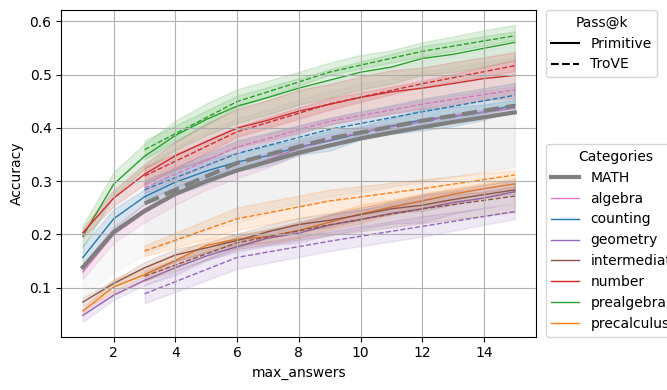

In [10]:
def plot_results(results, *, ax=None, x_scale=1,
                 style="-", show_labels=True,
                 add_reference_lines=False):
    """
    Plot `results` on `ax` with a given line `style` ("-" or "--", …).

    `show_labels`:
        True  → the first time you plot a category, include its legend label
        False → subsequent passes for the same categories suppress labels,
                avoiding duplicates.
    """
    if ax is None:
        _, ax = plt.subplots()

    x = (np.arange(1, len(next(iter(results.values()))["mean"]) + 1)
         * x_scale)

    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for idx, (category, stats) in enumerate(results.items()):
        color = color_cycle[idx % len(color_cycle)]
        label = category if show_labels else None

        means, stds = stats["mean"], stats["std"]
        is_math = category == "MATH"
        linewidth = 3.0 if is_math else 1.0
        alpha_fill = 0.05 if is_math else 0.15
        zorder = 10 if is_math else 1  # ensures MATH is drawn on top

        ax.plot(x, means, label=label, color=color, linestyle=style,
                linewidth=linewidth, zorder=zorder)

        ax.fill_between(x,
                        np.array(means) - np.array(stds),
                        np.array(means) + np.array(stds),
                        alpha=alpha_fill,
                        color=color,
                        zorder=zorder)

    if add_reference_lines:
        for y in (0.25, 0.26, 0.08, 0.11, 0.25, 0.29, 0.17):
            ax.axhline(y, ls="--", lw=1, color="grey", alpha=0.3)

    ax.set_xlabel("max_answers")
    ax.set_ylabel("Accuracy")
    ax.grid(True)
    return ax

    
fig, ax = plt.subplots(figsize=(8, 4))

# primitive → solid line, keep category labels
plot_results(results_primitive, ax=ax, x_scale=1,
             style="-", show_labels=True, add_reference_lines=False)

# trove → dashed line, *no* category labels (avoids duplicates)
plot_results(results_trove, ax=ax, x_scale=3,
             style="--", show_labels=False, add_reference_lines=False)

# -----------------------------------------------------------------------
#ax.set_title("Primitive-oracle vs Trove-oracle – Accuracy vs max_answers")

# first legend: categories (solid colours, one entry per category)
#leg1 = ax.legend(title="Categories", loc="lower left",
#                 bbox_to_anchor=(1.02, 0), borderaxespad=0.)
handles, labels = ax.get_legend_handles_labels()

# Sort labels and corresponding handles alphabetically
sorted_labels_handles = sorted(zip(labels, handles), key=lambda x: x[0])
sorted_labels, sorted_handles = zip(*sorted_labels_handles)

# Create alphabetically sorted legend
leg1 = ax.legend(sorted_handles, sorted_labels, title="Categories",
                 loc="lower left", bbox_to_anchor=(1.02, 0), borderaxespad=0.)


# second legend: dataset styles
style_handles = [
    Line2D([0], [0], color="black", linestyle="-", label="Primitive"),
    Line2D([0], [0], color="black", linestyle="--", label="TroVE"),
]
leg2 = ax.legend(handles=style_handles, title="Pass@k",
                 loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
ax.add_artist(leg1)   # keep the first legend when we add the second

fig.tight_layout(rect=[0, 0, 0.85, 1])  # reserve space on the right for the legend
fig.savefig("../images/sampling_both_oracles.pdf", bbox_inches="tight")
plt.show()

In [11]:
# The x locations that appear on the plot
x_values = [1, 3, 6, 9, 12, 15]

cats_no_math = sorted([c for c in results_primitive if c != "MATH"])
categories   = cats_no_math + ["MATH"]

def format_pair(p_val, t_val):
    if p_val == "" and t_val == "":
        return r"\,---", r"\,---"
    if p_val == "":
        return r"\,---", f"{t_val:.2f}"
    if t_val == "":
        return f"{p_val:.2f}", r"\,---"

    if p_val > t_val:
        return f"\\textbf{{{p_val:.2f}}}", f"{t_val:.2f}"
    elif t_val > p_val:
        return f"{p_val:.2f}", f"\\textbf{{{t_val:.2f}}}"
    else:                     # tie → bold both (or neither, your choice)
        return f"\\textbf{{{p_val:.2f}}}", f"\\textbf{{{t_val:.2f}}}"


# Build the LaTeX table -------------------------------------------------------
latex = []
latex.append(r"\begin{table}[ht]")
latex.append(r"\centering")
latex.append(r"\small")
pairs = ["rr"] * len(x_values)          # one “rr” per @k pair
colspec = "l " + " | ".join(pairs)      # glue them with vertical bars
latex.append(f"\\begin{{tabular}}{{{colspec}}}")
latex.append(r"\toprule")

# Header row
hdr = ["Category"]
for x in x_values:
    hdr += [f"P@{x}", f"T@{x}"]
latex.append(" & ".join(hdr) + r" \\")
latex.append(r"\midrule")

# Data rows
for cat in categories:
    if cat == "MATH":                 # ⇢ insert an extra midrule first
        latex.append(r"\midrule")

    p_stats = results_primitive[cat]
    t_stats = results_trove[cat]

    row_cells = [cat]
    for x in x_values:                # e.g. [1,3,6,9,12,15]
        p_idx = x - 1
        t_idx = x // 3 - 1 if x % 3 == 0 else None

        p_val = p_stats["mean"][p_idx] if p_idx < len(p_stats["mean"]) else ""
        t_val = (
            t_stats["mean"][t_idx] if t_idx is not None and t_idx < len(t_stats["mean"]) else ""
        )

        p_fmt, t_fmt = format_pair(p_val, t_val)   # bold-higher
        row_cells.extend([p_fmt, t_fmt])

    latex.append(" & ".join(row_cells) + r" \\")

latex.append(r"\bottomrule")
latex.append(r"\end{tabular}")
latex.append(r"\caption{Primitive (P) and Trove (T) accuracies at the "
             r"max\_answers values used in the plot. Blank entries mean "
             r"no Trove point was plotted at that $x$.}")
latex.append(r"\end{table}")

print("\n".join(latex))

\begin{table}[ht]
\centering
\small
\begin{tabular}{l rr | rr | rr | rr | rr | rr}
\toprule
Category & P@1 & T@1 & P@3 & T@3 & P@6 & T@6 & P@9 & T@9 & P@12 & T@12 & P@15 & T@15 \\
\midrule
algebra & 0.13 & \,--- & 0.24 & \textbf{0.29} & 0.32 & \textbf{0.36} & 0.38 & \textbf{0.41} & 0.41 & \textbf{0.44} & 0.44 & \textbf{0.47} \\
counting & 0.16 & \,--- & 0.27 & \textbf{0.28} & 0.34 & \textbf{0.35} & 0.38 & \textbf{0.40} & 0.42 & \textbf{0.43} & 0.44 & \textbf{0.46} \\
geometry & 0.05 & \,--- & \textbf{0.11} & 0.09 & \textbf{0.18} & 0.16 & \textbf{0.22} & 0.19 & \textbf{0.25} & 0.22 & \textbf{0.28} & 0.24 \\
intermediate & 0.07 & \,--- & \textbf{0.14} & 0.12 & \textbf{0.19} & 0.18 & \textbf{0.23} & 0.22 & \textbf{0.25} & 0.25 & \textbf{0.28} & 0.27 \\
number & 0.20 & \,--- & \textbf{0.31} & 0.31 & \textbf{0.40} & 0.39 & 0.44 & \textbf{0.45} & 0.47 & \textbf{0.48} & 0.50 & \textbf{0.52} \\
prealgebra & 0.20 & \,--- & 0.35 & \textbf{0.36} & 0.44 & \textbf{0.45} & 0.49 & \textbf{0.50} & 0.5

### Plotting for up to K=75

We combine all runs by all five seeds and plot for up to K=75

In [12]:
solutions_primitive = get_collective_primitive_responses(primitive_path)
solutions_import, solutions_create, solutions_skip = get_collective_trove_responses(trove_path)

# Compute weighted average accuracy for each budget
def compute_weighted_average(accuracy_dict, task_totals, budgets):
    weighted_accuracies = []
    for b in range(len(budgets)):
        total_weighted_accuracy = 0
        total_samples = 0
        for trove in accuracy_dict:
            if trove in task_totals:
                total_weighted_accuracy += accuracy_dict[trove][b] * task_totals[trove]
                total_samples += task_totals[trove]
        weighted_accuracies.append(total_weighted_accuracy / total_samples)
    return weighted_accuracies

#### Normal Data from majority voting

In [13]:
# same for Majority Voting
# 
#from utils import select_best_solution
#import matplotlib.pyplot as plt
#from tqdm import tqdm   

#try read primitive_accuracies_maj_voting.json, else compute it
try:
    with open("primitive_accuracies_maj_voting.json", "r") as f:
        primitive_accuracies_maj_voting = json.load(f)
except:
    primitive_accuracies_maj_voting = {trove: [] for trove in solutions_primitive}

    # Loop over each budget value
    for budget in tqdm(range(1, 76)):  # From 1 to 75
        #print(budget)
        for trove in solutions_primitive:
            accuracy = 0
            total = len(solutions_primitive[trove])
            for j in solutions_primitive[trove]:
                sol_helper = solutions_primitive[trove][j][:budget]
                best_idx = select_best_solution(sol_helper)
                if solutions_primitive[trove][j][best_idx]["is_correct"]:
                    accuracy += 1
            primitive_accuracies_maj_voting[trove].append(accuracy / total)
    #print(primitive_accuracies)

primitive_math_maj_voting = compute_weighted_average(primitive_accuracies_maj_voting, task_totals, range(1, 76))

#try read trove_accuracies_maj_voting.json, else compute it
try:
    with open("trove_accuracies_maj_voting.json", "r") as f:
        trove_accuracies_maj_voting = json.load(f)
except:
    trove_accuracies_maj_voting = {trove: [] for trove in solutions_import}

    for budget in tqdm(range(1, 26)):
        for trove in solutions_import:
            accuracy = 0
            total = len(solutions_import[trove])
            for j in solutions_import[trove]:
                sol_helper_import = solutions_import[trove][j][:budget]
                sol_helper_create = solutions_create[trove][j][:budget]
                sol_helper_skip = solutions_skip[trove][j][:budget]

                best_idx_import = select_best_solution(sol_helper_import)
                best_idx_create = select_best_solution(sol_helper_create)
                best_idx_skip = select_best_solution(sol_helper_skip)
                
                resp_list = [sol_helper_import[best_idx_import], sol_helper_create[best_idx_create], sol_helper_skip[best_idx_skip]]
                best_idx = select_best_solution(resp_list)
                if resp_list[best_idx]["is_correct"]:
                    accuracy += 1
            trove_accuracies_maj_voting[trove].append(accuracy / total)

    with open("trove_accuracies_maj_voting.json", "w") as f:
        json.dump(trove_accuracies_maj_voting, f)



trove_math_maj_voting = compute_weighted_average(trove_accuracies_maj_voting, task_totals, range(1, 26))

#try read trove_accuracies_maj_voting.json, else compute it
try:
    with open("trove_new_eval_accuracies_maj_voting.json", "r") as f:
        trove_new_eval_accuracies_maj_voting = json.load(f)
except:
    trove_new_eval_accuracies_maj_voting = {trove: [] for trove in solutions_import}

    for budget in tqdm(range(1, 26)):
        for trove in solutions_import:
            accuracy = 0
            total = len(solutions_import[trove])
            for j in solutions_import[trove]:
                sol_helper_import = solutions_import[trove][j][:budget]
                sol_helper_create = solutions_create[trove][j][:budget]
                sol_helper_skip = solutions_skip[trove][j][:budget]

                #concatenate sol_helper_import, sol_helper_create, sol_helper_skip into one list
                resp_list = sol_helper_import + sol_helper_create + sol_helper_skip
                best_idx = select_best_solution(resp_list)
                if resp_list[best_idx]["is_correct"]:
                    accuracy += 1
            trove_new_eval_accuracies_maj_voting[trove].append(accuracy / total)

    with open("trove_new_eval_accuracies_maj_voting.json", "w") as f:
        json.dump(trove_new_eval_accuracies_maj_voting, f)

trove_new_eval_math_maj_voting = compute_weighted_average(trove_new_eval_accuracies_maj_voting, task_totals, range(1, 26))


#### Oracle Data

In [14]:
if os.path.exists("primitive_75.json"):
    with open("primitive_75.json", "r") as f:
        primitive_accuracies = json.load(f)
else:
    # Store accuracy for each trove across budgets
    primitive_accuracies = {trove: [] for trove in solutions_primitive}

    # Loop over each budget value
    for budget in range(1, 76):  # From 1 to 75
        for trove in solutions_primitive:
            accuracy = 0
            total = len(solutions_primitive[trove])
            for j in solutions_primitive[trove]:
                for i in range(min(budget, len(solutions_primitive[trove][j]))):
                    if solutions_primitive[trove][j][i]["is_correct"]:
                        accuracy += 1
                        break
            primitive_accuracies[trove].append(accuracy / total)
    
    with open("primitive_75.json", "w") as f:
        json.dump(primitive_accuracies, f)


if os.path.exists("trove_75.json"):
    with open("trove_75.json", "r") as f:
        trove_accuracies = json.load(f)
else:


    trove_accuracies = {trove: [] for trove in solutions_import}

    for budget in range(1, 26):
        for trove in solutions_import:
            accuracy = 0
            total = len(solutions_import[trove])
            for j in solutions_import[trove]:
                solved = False
                for i in range(min(budget, len(solutions_import[trove][j]))):
                    if solutions_import[trove][j][i]["is_correct"]:
                        accuracy += 1
                        solved = True
                        break
                if not solved:
                    for i in range(min(budget, len(solutions_create[trove][j]))):
                        if solutions_create[trove][j][i]["is_correct"]:
                            accuracy += 1
                            solved = True
                            break
                if not solved:
                    for i in range(min(budget, len(solutions_skip[trove][j]))):
                        if solutions_skip[trove][j][i]["is_correct"]:
                            accuracy += 1
                            break
            trove_accuracies[trove].append(accuracy / total)



primitive_math = compute_weighted_average(primitive_accuracies, task_totals, range(1, 76))
trove_math = compute_weighted_average(trove_accuracies, task_totals, range(1, 26))


#### Plot

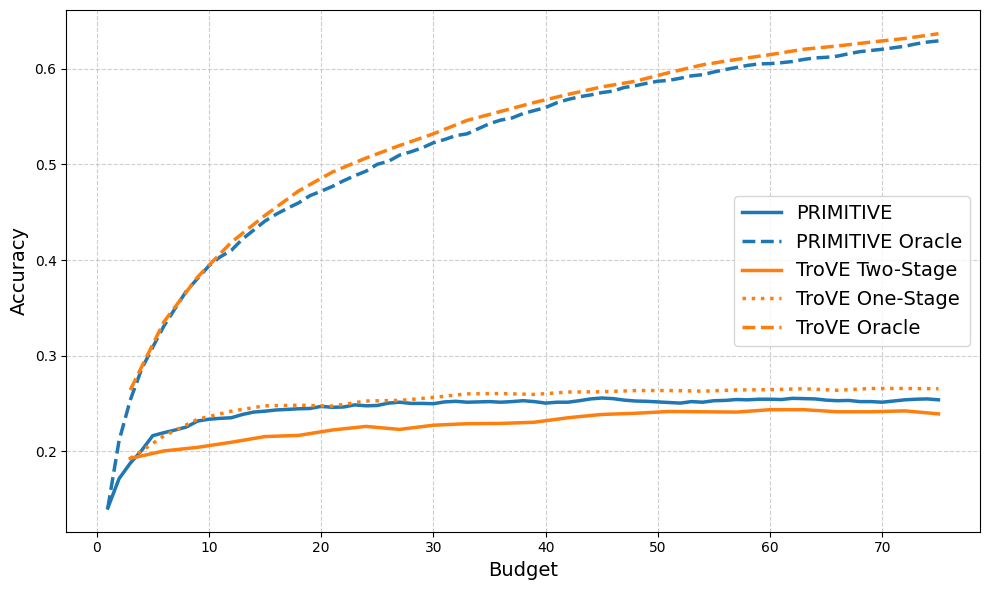

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Define fixed colors
primitive_color = '#1f77b4'  # Blue from tab10
trove_color = '#ff7f0e'      # Orange from tab10

# Plot Primitive lines (all blue)
plt.plot(range(1, 76), primitive_math_maj_voting, label="PRIMITIVE",
         color=primitive_color, linestyle='-', linewidth=2.5)
plt.plot(range(1, 76), primitive_math, label="PRIMITIVE Oracle",
         color=primitive_color, linestyle='--', linewidth=2.5)

# Plot Trove lines (all orange)
plt.plot([x * 3 for x in range(1, 26)], trove_math_maj_voting, label="TroVE Two-Stage",
         color=trove_color, linestyle='-', linewidth=2.5)
plt.plot([x * 3 for x in range(1, 26)], trove_new_eval_math_maj_voting, label="TroVE One-Stage",
         color=trove_color, linestyle=':', linewidth=2.5)
plt.plot([x * 3 for x in range(1, 26)], trove_math, label="TroVE Oracle",
         color=trove_color, linestyle='--', linewidth=2.5)


# Labels and styling
plt.xlabel("Budget", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='center right', frameon=True, fontsize='14')
plt.tight_layout()
plt.savefig("../images/accuracy_vs_budget_self_consistency.pdf", dpi=300)
plt.show()

## Evaluating TroVE's modes

In [16]:
primitive_solutions = get_n_solved(primitive_path, trove_or_prim="primitive_oracle", max_answers=5)
solutions_trove = get_trove_solved(trove_path)

### Comparing Primitive and TroVE's modes

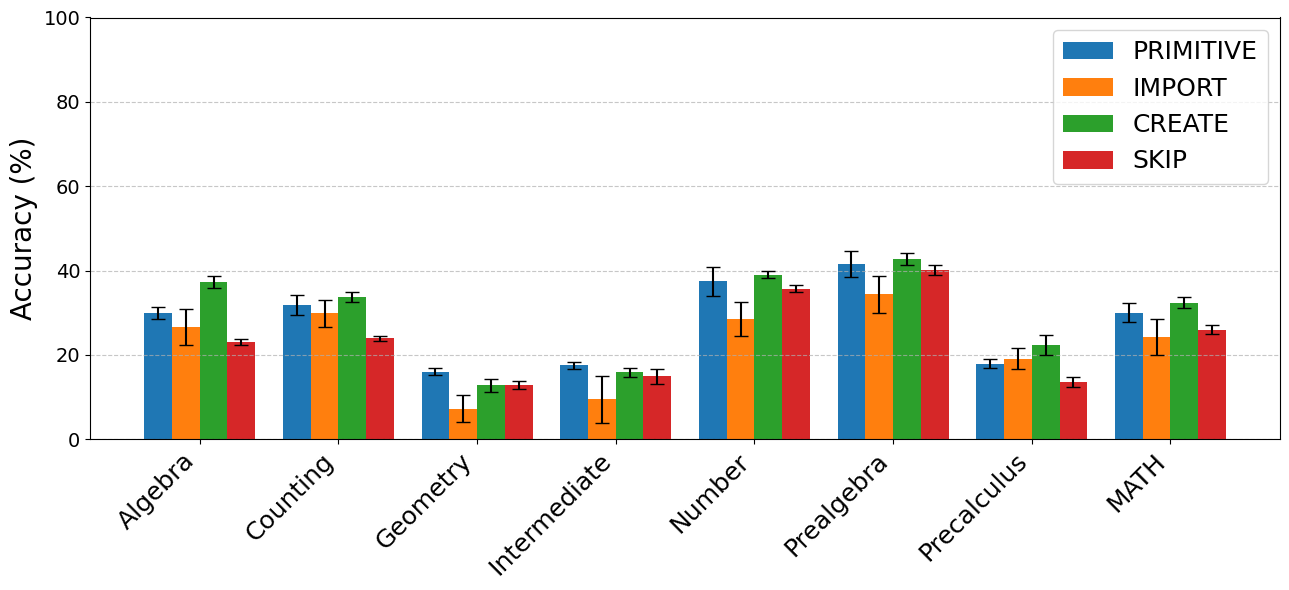

In [17]:

modes = ["primitive", "import", "create", "skip"]
all_trove_dirs = sorted(task_totals.keys())

mean_by_dir = {mode: [] for mode in modes}
std_by_dir = {mode: [] for mode in modes}
trove_labels = []

# For aggregation
aggregated_means = {mode: [] for mode in modes}
aggregated_vars = {mode: [] for mode in modes}
total_tasks_all = 0

for trove_dir in all_trove_dirs:
    trove_labels.append(trove_dir)
    total = task_totals[trove_dir]
    total_tasks_all += total

    # Primitive
    if trove_dir in primitive_solutions:
        runs = primitive_solutions[trove_dir]
        lengths = [len(solved_set) for solved_set in runs]
    else:
        lengths = []
    percents = [l / total * 100 for l in lengths]
    m = np.mean(percents) if percents else 0
    s = np.std(percents) if percents else 0
    mean_by_dir["primitive"].append(m)
    std_by_dir["primitive"].append(s)
    aggregated_means["primitive"].append(m * total)
    aggregated_vars["primitive"].append((s ** 2) * total)

    # Trove modes
    for mode in ["import", "create", "skip"]:
        if trove_dir in solutions_trove and mode in solutions_trove[trove_dir]:
            runs = solutions_trove[trove_dir][mode]
            lengths = [len(solved_set) for solved_set in runs]
        else:
            lengths = []
        percents = [l / total * 100 for l in lengths]
        m = np.mean(percents) if percents else 0
        s = np.std(percents) if percents else 0
        mean_by_dir[mode].append(m)
        std_by_dir[mode].append(s)
        aggregated_means[mode].append(m * total)
        aggregated_vars[mode].append((s ** 2) * total)

# Append "All (Math)" aggregated results
trove_labels.append("MATH")
for mode in modes:
    if total_tasks_all > 0:
        agg_mean = sum(aggregated_means[mode]) / total_tasks_all
        pooled_std = np.sqrt(sum(aggregated_vars[mode]) / total_tasks_all)
    else:
        agg_mean = 0.0
        pooled_std = 0.0
    mean_by_dir[mode].append(agg_mean)
    std_by_dir[mode].append(pooled_std)

# --- Plotting ---
x = np.arange(len(trove_labels))
width = 0.2
offsets = [-1.5, -0.5, 0.5, 1.5]

plt.figure(figsize=(13, 6))

for i, mode in enumerate(modes):
    plt.bar(
        x + offsets[i] * width,
        mean_by_dir[mode],
        width,
        label=mode.upper(),
        yerr=std_by_dir[mode],
        capsize=5
    )

plt.xticks(x, [label.capitalize() if label != "MATH" else label for label in trove_labels], rotation=45, ha="right", fontsize=18)
plt.ylabel("Accuracy (%)", fontsize=20)
#plt.title("Percentage of Solved Tasks per Mode and Trove Category (+ Aggregated)")
plt.ylim(0, 100)
plt.tick_params(axis='y', labelsize=14)
plt.legend(fontsize=18)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("../images/solved_across_modes.pdf", bbox_inches="tight")
plt.show()

### Calculating Jaccard Similarity

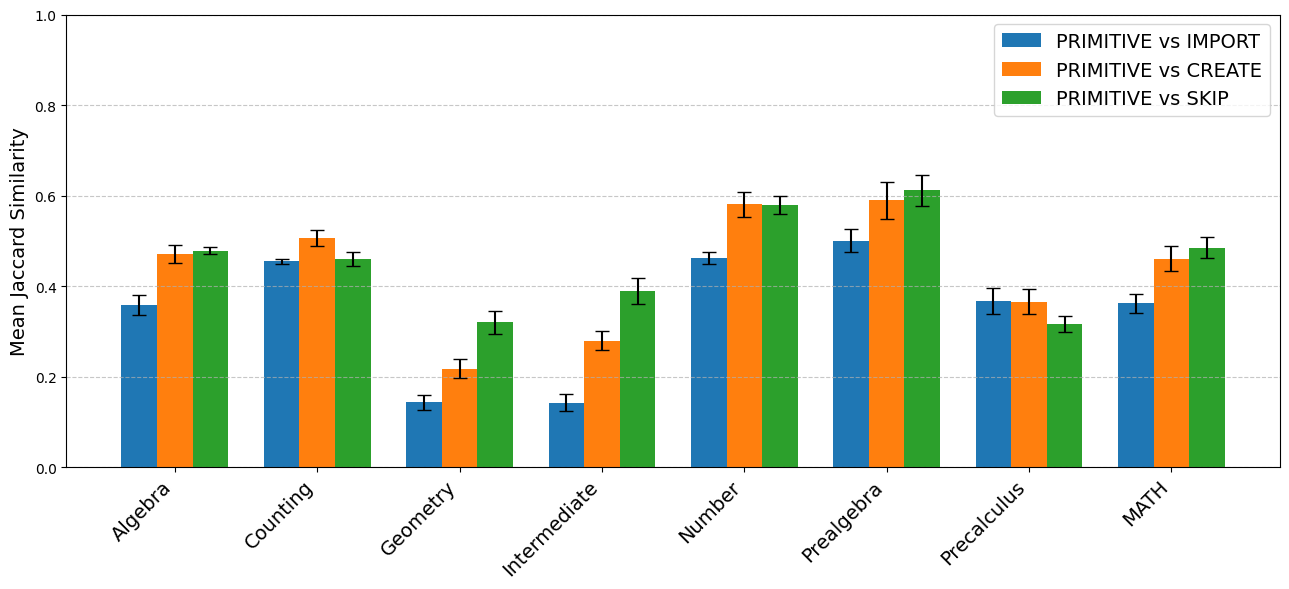

In [18]:
# === Collect means/stds per trove_dir per mode ===
jaccard_stats = defaultdict(dict)

def jaccard(set1, set2):
    if not set1 and not set2:
        return 1.0
    union = set1 | set2
    if not union:
        return 0.0
    return len(set1 & set2) / len(union)

for trove_dir in primitive_solutions:
    primitive_runs = [set(p) for p in primitive_solutions[trove_dir]]

    for mode in ["import", "create", "skip"]:
        mode_runs = (
            [set(m) for m in solutions_trove.get(trove_dir, {}).get(mode, [])]
            if trove_dir in solutions_trove else []
        )

        if not primitive_runs or not mode_runs:
            jaccard_stats[trove_dir][mode] = (None, None)
            continue

        all_means = []
        for p in primitive_runs:
            jaccards = [jaccard(p, m) for m in mode_runs]
            all_means.append(mean(jaccards))

        jaccard_stats[trove_dir][mode] = (
            mean(all_means),
            stdev(all_means) if len(all_means) > 1 else 0.0
        )

# === Aggregate values for plotting ===
modes = ["import", "create", "skip"]
trove_dirs = sorted(jaccard_stats.keys())

means_by_mode = {mode: [] for mode in modes}
stds_by_mode = {mode: [] for mode in modes}

# For aggregation
aggregated_mean = {}
aggregated_std = {}

for mode in modes:
    weighted_means = []
    weighted_variances = []
    total_tasks = 0

    for trove_dir in trove_dirs:
        mean_val, std_val = jaccard_stats[trove_dir].get(mode, (0.0, 0.0))
        task_count = task_totals.get(trove_dir, 0)

        if mean_val is not None:
            means_by_mode[mode].append(mean_val)
            stds_by_mode[mode].append(std_val)
            weighted_means.append(mean_val * task_count)
            weighted_variances.append((std_val ** 2) * task_count)
            total_tasks += task_count
        else:
            means_by_mode[mode].append(0.0)
            stds_by_mode[mode].append(0.0)

    if total_tasks > 0:
        weighted_mean = sum(weighted_means) / total_tasks
        pooled_std = np.sqrt(sum(weighted_variances) / total_tasks)
    else:
        weighted_mean, pooled_std = 0.0, 0.0

    aggregated_mean[mode] = weighted_mean
    aggregated_std[mode] = pooled_std

# Append the aggregated "All (Math)" row
for mode in modes:
    means_by_mode[mode].append(aggregated_mean[mode])
    stds_by_mode[mode].append(aggregated_std[mode])

trove_dirs.append("MATH")

# === Plotting ===
x = np.arange(len(trove_dirs))
width = 0.25
offsets = [-width, 0, width]

plt.figure(figsize=(13, 6))

for i, mode in enumerate(modes):
    plt.bar(
        x + offsets[i],
        means_by_mode[mode],
        width,
        yerr=stds_by_mode[mode],
        capsize=5,
        label=f"PRIMITIVE vs {mode.upper()}"
    )

plt.xticks(x, [td.capitalize() if td != "MATH" else td for td in trove_dirs], rotation=45, ha="right", fontsize=14)
plt.ylabel("Mean Jaccard Similarity", fontsize=14)
plt.ylim(0, 1)
#plt.title("Jaccard Similarity: Primitive vs Import/Create/Skip (+ Aggregated)")
plt.legend(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("../images/jaccard_across_modes.pdf", bbox_inches="tight")
plt.show()

## Diversity of Solutions

We analyze which tasks are only solved by Primitive or TroVE to evaluate TroVe's potential.

In [19]:
div_primitive = get_solution_diversity(primitive_path, trove_or_primitive="primitive")

div_trove = get_solution_diversity(trove_path, trove_or_primitive="trove")

In [20]:
# Generate LaTeX table (compact format with differences)
all_keys = sorted(set(div_primitive.keys()).union(div_trove.keys()))

latex_table = []

latex_table.append(r"\begin{tabular}{lcc|c}" + "\n")
latex_table.append(r"\toprule" + "\n")
latex_table.append(r"Category & Primitive & TroVE & $\Delta$ \\" + "\n")
latex_table.append(r"\midrule" + "\n")

all_math_primitive = 0
all_math_primitive_std = 0
all_math_trove = 0
all_math_trove_std = 0

for k in all_keys:
    p = div_primitive.get(k, {})
    t = div_trove.get(k, {})
    p_mean = p.get("mean", 0)
    p_std = p.get("std", 0)
    t_mean = t.get("mean", 0)
    t_std = t.get("std", 0)
    diff = t_mean - p_mean

    all_math_primitive += p_mean * task_totals[k]
    all_math_trove += t_mean * task_totals[k]

    all_math_primitive_std += p_std * task_totals[k]
    all_math_trove_std += t_std * task_totals[k]


    row = (
        f"{k} & "
        f"${p_mean:.2f} \pm {p_std:.2f}$ & "
        f"${t_mean:.2f} \pm {t_std:.2f}$ & "
        f"{diff:+.2f} \\\\"
    )
    latex_table.append(row + "\n")

all_math_primitive = all_math_primitive / total_tasks
all_math_trove = all_math_trove / total_tasks
all_math_primitive_std = all_math_primitive_std / total_tasks
all_math_trove_std = all_math_trove_std / total_tasks

diff =  all_math_trove - all_math_primitive

row = (
        f"MATH & "
        f"${all_math_primitive:.2f} \pm {all_math_primitive_std:.2f}$ & "
        f"${all_math_trove:.2f} \pm {all_math_trove_std:.2f}$ & "
        f"{diff:+.2f} \\\\"
)

latex_table.append(r"\midrule" + "\n")
latex_table.append(row + "\n")



latex_table.append(r"\bottomrule" + "\n")
latex_table.append(r"\end{tabular}")

# Print the LaTeX table
print("".join(latex_table))

\begin{tabular}{lcc|c}
\toprule
Category & Primitive & TroVE & $\Delta$ \\
\midrule
algebra & $4.20 \pm 0.04$ & $4.83 \pm 0.15$ & +0.64 \\
counting & $5.94 \pm 0.06$ & $6.77 \pm 0.13$ & +0.83 \\
geometry & $6.79 \pm 0.66$ & $6.64 \pm 0.41$ & -0.15 \\
intermediate & $3.89 \pm 0.06$ & $4.09 \pm 0.25$ & +0.20 \\
number & $4.88 \pm 0.64$ & $5.78 \pm 0.19$ & +0.90 \\
prealgebra & $5.18 \pm 0.04$ & $6.47 \pm 0.16$ & +1.29 \\
precalculus & $3.36 \pm 0.12$ & $4.83 \pm 0.14$ & +1.47 \\
\midrule
MATH & $4.76 \pm 0.19$ & $5.50 \pm 0.19$ & +0.74 \\
\bottomrule
\end{tabular}


## Performance across MATH levels

In [21]:
from math_levels import compute_level_distributions, get_n_solutions, compute_mean_percent_per_level, compute_level_distributions, load_levels

# Load level data and totals
level_data, level_totals = load_levels("../data")

# Primitive
solution_indices_prim = get_n_solutions(primitive_path, trove_or_prim="primitive_oracle", max_answers=15)
level_distributions_prim = compute_level_distributions(solution_indices_prim, level_data, level_totals)

# Trove
solution_indices_trove = get_n_solutions(trove_path, trove_or_prim="trove_oracle", max_answers=5)
level_distributions_trove = compute_level_distributions(solution_indices_trove, level_data, level_totals)

# Print results
for category, seeds in level_distributions_prim.items():
    print(f"Category: {category} (Primitive)")
    for i, dist in enumerate(seeds):
        print(f"  Seed {i}: { {k: round(v, 2) for k, v in dist.items()} }")

for category, seeds in level_distributions_trove.items():
    print(f"Category: {category} (Trove)")
    for i, dist in enumerate(seeds):
        print(f"  Seed {i}: { {k: round(v, 2) for k, v in dist.items()} }")

Category: counting (Primitive)
  Seed 0: {2: 61.04, 3: 49.15, 1: 74.19, 5: 16.36, 4: 30.43}
  Seed 1: {2: 62.34, 3: 44.07, 1: 77.42, 5: 14.55, 4: 27.54}
  Seed 2: {2: 63.64, 3: 45.76, 1: 77.42, 5: 10.91, 4: 36.23}
  Seed 3: {2: 61.04, 3: 49.15, 1: 77.42, 5: 12.73, 4: 28.99}
  Seed 4: {2: 67.53, 3: 45.76, 1: 77.42, 5: 12.73, 4: 33.33}
Category: precalculus (Primitive)
  Seed 0: {4: 25.0, 2: 37.93, 1: 65.52, 5: 11.11, 3: 14.71}
  Seed 1: {2: 44.83, 3: 20.59, 4: 21.43, 1: 65.52, 5: 8.33}
  Seed 2: {2: 37.93, 3: 23.53, 5: 8.33, 1: 65.52, 4: 17.86}
  Seed 3: {2: 48.28, 3: 14.71, 4: 21.43, 1: 62.07, 5: 11.11}
  Seed 4: {2: 37.93, 3: 20.59, 4: 10.71, 5: 11.11, 1: 62.07}
Category: prealgebra (Primitive)
  Seed 0: {3: 58.99, 5: 33.06, 2: 78.52, 4: 51.61, 1: 81.97}
  Seed 1: {3: 53.37, 5: 34.68, 2: 71.14, 4: 56.45, 1: 77.05}
  Seed 2: {3: 59.55, 5: 30.65, 2: 72.48, 4: 51.61, 1: 81.97}
  Seed 3: {2: 69.8, 5: 33.87, 4: 52.42, 3: 56.18, 1: 83.61}
  Seed 4: {3: 47.75, 5: 27.42, 2: 66.44, 4: 44.35, 1

In [22]:
# build weighted "All math" for Primitive and Trove

mean_per_level_prim  = compute_mean_percent_per_level(level_distributions_prim)
mean_per_level_trove = compute_mean_percent_per_level(level_distributions_trove)


# gather all cats and levels
categories = sorted(set(mean_per_level_prim) | set(mean_per_level_trove))
all_levels = sorted({
    lvl
    for d in chain(mean_per_level_prim.values(), mean_per_level_trove.values())
    for lvl in d.keys()
})

rows = []
index = []

for cat in categories:
    # get the two dicts (default to empty so .get() yields 0)
    prim_means  = mean_per_level_prim.get(cat, {})
    trove_means = mean_per_level_trove.get(cat, {})
    # build row in the same order
    rows.append([ prim_means.get(lvl, 0.0) for lvl in all_levels ])
    index.append((cat, "Primitive"))
    rows.append([ trove_means.get(lvl, 0.0) for lvl in all_levels ])
    index.append((cat, "Trove"))

df_means = pd.DataFrame(
    rows,
    index=pd.MultiIndex.from_tuples(index, names=["Category","Type"]),
    columns=[f"Level {l}" for l in all_levels],
)
#print(df_means.to_latex(float_format="%.2f", na_rep="-"))


all_rows = []
all_index = []
for kind, mean_dict in [("Primitive", mean_per_level_prim),
                        ("Trove", mean_per_level_trove)]:
    weighted = []
    for lvl in all_levels:
        # numerator: sum over cats (mean% * #tasks)
        num = sum(
            mean_dict.get(cat,{}).get(lvl, 0.0)/100.0 * level_totals[cat].get(lvl, 0)
            for cat in categories
        )
        # denominator: total tasks at that level across cats
        denom = sum(level_totals[cat].get(lvl,0) for cat in categories)
        weighted.append((num/denom)*100 if denom else 0.0)
    all_rows.append(weighted)
    all_index.append(("MATH", kind))

# append to df_means
df_weighted = pd.DataFrame(
    all_rows,
    index=pd.MultiIndex.from_tuples(all_index, names=["Category","Method"]),
    columns=df_means.columns
)
df_final = pd.concat([df_means, df_weighted])
#print(df_final.to_latex(float_format="%.2f", na_rep="-"))
df_final.index = pd.MultiIndex.from_tuples(
    [(cat.title(), typ) for cat, typ in df_final.index],
    names=df_final.index.names
)
latex_str = df_final.to_latex(
    float_format="%.2f",
    na_rep="-",
    multirow=True,
    column_format="ll" + "r" * len(df_final.columns),
    escape=False
)

# Remove [t] from all multirow commands to center them vertically
latex_str = latex_str.replace(r'\multirow[t]{', r'\multirow{')

print(latex_str)

\begin{tabular}{llrrrrr}
\toprule
 &  & Level 1 & Level 2 & Level 3 & Level 4 & Level 5 \\
Category &  &  &  &  &  &  \\
\midrule
\multirow{2}{*}{Algebra} & Primitive & 75.52 & 59.37 & 47.92 & 31.96 & 19.18 \\
 & Trove & 84.00 & 65.28 & 52.08 & 33.40 & 18.78 \\
\cline{1-7}
\multirow{2}{*}{Counting} & Primitive & 76.77 & 63.12 & 46.78 & 31.30 & 13.45 \\
 & Trove & 79.35 & 63.64 & 52.88 & 30.14 & 15.64 \\
\cline{1-7}
\multirow{2}{*}{Geometry} & Primitive & 38.62 & 44.44 & 25.20 & 27.30 & 10.80 \\
 & Trove & 35.86 & 38.22 & 24.00 & 22.54 & 7.60 \\
\cline{1-7}
\multirow{2}{*}{Intermediate} & Primitive & 60.00 & 46.47 & 35.00 & 23.01 & 13.79 \\
 & Trove & 64.29 & 48.82 & 35.00 & 20.68 & 10.21 \\
\cline{1-7}
\multirow{2}{*}{Number} & Primitive & 85.52 & 68.15 & 57.50 & 45.45 & 30.35 \\
 & Trove & 83.45 & 66.91 & 57.14 & 47.12 & 36.50 \\
\cline{1-7}
\multirow{2}{*}{Prealgebra} & Primitive & 79.02 & 71.68 & 55.17 & 51.29 & 31.94 \\
 & Trove & 80.98 & 70.47 & 58.31 & 52.90 & 32.74 \\
\cline{1-7